# Regularization for Linear Models
In the following lab you will experience fitting a linear model with lasso and ridge regularizations.

You will be using the "Hitters" dataset, containing major league baseball data from the 1986 and 1987 seasons.
Dataset taken from "An Introduction to Statistical Learning with applications in R" (Retrieved via ISLR package in R).

The dataset consists of 322 observations of major league players on the following 20 variables. The response variable is "Salary"  

In [0]:
from google.colab import drive
# drive.mount('/content/drive')
%cd "/content/drive/My Drive/Colab Notebooks/'IML labs'/"
!ls

In [0]:
import pandas as pd
from pandas import DataFrame
pd.read_csv("HittersDescription.csv", encoding = "ISO-8859-1")

,Feature,Description
0,AtBat,Number of times at bat in 1986
1,Hits,Number of hits in 1986
2,HmRun,Number of home runs in 1986
3,Runs,Number of runs in 1986
4,RBI,Number of runs batted in in 1986
5,Walks,Number of walks in 1986
6,Years,Number of years in the major leagues
7,CAtBat,Number of times at bat during his career
8,Chits,Number of hits during his career
9,CHmRun,Number of home runs during his career


In [0]:
df = pd.read_csv("Hitters.csv")
df


,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague,Player
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A,-Andy Allanson
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N,-Alan Ashby
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A,-Alvin Davis
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N,-Andre Dawson
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N,-Andres Galarraga
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,497,127,7,65,48,37,5,2703,806,32,379,311,138,N,E,325,9,3,700.0,N,-Willie McGee
318,492,136,5,76,50,94,12,5511,1511,39,897,451,875,A,E,313,381,20,875.0,A,-Willie Randolph
319,475,126,3,61,43,52,6,1700,433,7,217,93,146,A,W,37,113,7,385.0,A,-Wayne Tolleson
320,573,144,9,85,60,78,8,3198,857,97,470,420,332,A,E,1314,131,12,960.0,A,-Willie Upshaw


# Pre-processing
Most of the features of this dataset are numeric. For simplicity let us remove all textual categorical features, and deal only with numerical features.

In [0]:
df = df.drop(["Player", "League", "Division", "NewLeague"], 1).dropna()
df

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,632,43,10,475.0
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,880,82,14,480.0
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,200,11,3,500.0
4,321,87,10,39,42,30,2,396,101,12,48,46,33,805,40,4,91.5
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,282,421,25,750.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,497,127,7,65,48,37,5,2703,806,32,379,311,138,325,9,3,700.0
318,492,136,5,76,50,94,12,5511,1511,39,897,451,875,313,381,20,875.0
319,475,126,3,61,43,52,6,1700,433,7,217,93,146,37,113,7,385.0
320,573,144,9,85,60,78,8,3198,857,97,470,420,332,1314,131,12,960.0


# Fitting an OLS Model
As a baseline consider fitting an Ordinary Least Square model over the data, predicting the relationship between all the 
explanatory variables and the response, the player's salary. 

In [0]:
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

np.random.seed(0)

train, test = train_test_split(df, test_size=0.2)
trainX, trainY, testX, testY = train.loc[:, train.columns != 'Salary'], train["Salary"], test.loc[:, test.columns != 'Salary'], test["Salary"]

print("After splitting, we got %d train samples and %d test samples" % (len(train), len(test)))


After splitting, we got 210 train samples and 53 test samples


In [0]:
ols = LinearRegression().fit(trainX, trainY)
print("Train Error: %f\nTest Error: %f" % (mean_squared_error(trainY, ols.predict(trainX)), 
                                           mean_squared_error(testY, ols.predict(testX))))

DataFrame({"Feature": trainX.columns, "Coefficient": ols.coef_})

Train Error: 90145.406048
Test Error: 132925.004453


,Feature,Coefficient
0,AtBat,-2.015452
1,Hits,7.520141
2,HmRun,9.312551
3,Runs,-1.719625
4,RBI,-2.340944
5,Walks,7.285795
6,Years,7.682881
7,CAtBat,-0.165969
8,CHits,0.274872
9,CHmRun,-0.531528


# Fitting a Regularized LS Model

Recall that the lasso and ridge optimization problems: 

$$ \widehat{\beta}^{lasso}=\underset{\beta}{argmin} \left[ \left|\left|y-X^{\top}\beta\right|\right|_2 + \lambda \left|\left|\beta\right|\right|_1 \right] $$

$$ \widehat{\beta}^{ridge}=\underset{\beta}{argmin} \left[ \left|\left|y-X^{\top}\beta\right|\right|_2 + \lambda \left|\left|\beta\right|\right|_2 \right] $$

That is, we are searching for $\beta$ that minimizes the squared-loss together with the regularization term.

In [0]:
from sklearn.linear_model import Lasso, Ridge

# sklearn calls the `lambda` parameter `alpha`. The reasoning for these alpha values are addressed at the end of the lab
lasso = Lasso(alpha=538).fit(trainX, trainY)
ridge = Ridge(alpha=10).fit(trainX, trainY)
DataFrame({"Feature": trainX.columns, "OLS Coefficient": ols.coef_, 
           "Lasso Coefficients": lasso.coef_, "Ridge Coefficients": ridge.coef_})

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3920.834705557674, tolerance: 3759.109166869193
  positive)


,Feature,OLS Coefficient,Lasso Coefficients,Ridge Coefficients
0,AtBat,-2.015452,-0.000000,-2.015851
1,Hits,7.520141,1.846434,7.509092
2,HmRun,9.312551,0.000000,9.240051
3,Runs,-1.719625,0.000000,-1.700787
4,RBI,-2.340944,0.000000,-2.315588
5,Walks,7.285795,1.675099,7.275961
6,Years,7.682881,0.000000,7.535395
7,CAtBat,-0.165969,-0.239991,-0.165432
8,CHits,0.274872,0.723843,0.275825
9,CHmRun,-0.531528,0.000000,-0.523110


In [0]:
DataFrame({"Model": ["OLS", "Lasso", "Ridge"],
           "Train Error": [mean_squared_error(trainY, ols.predict(trainX)),
                           mean_squared_error(trainY, lasso.predict(trainX)),
                           mean_squared_error(trainY, ridge.predict(trainX))],
           "Test Error": [mean_squared_error(testY, ols.predict(testX)),
                          mean_squared_error(testY, lasso.predict(testX)),
                          mean_squared_error(testY, ridge.predict(testX))]})


,Model,Train Error,Test Error
0,OLS,90145.406048,132925.004453
1,Lasso,97948.099107,129543.858986
2,Ridge,90145.504711,132810.538948


# Plotting Lasso- and Ridge Regularization Path
Next, by fitting lasso- and ridge models over the training data, with multiple $\lambda$ values we can plot
the change in coefficients as a function of $\lambda$. This is called the regularization path.

Please implement the functions below.

In [0]:
import numpy as np
lambdas = 10**np.linspace(3,-3, 50)
lambdas


array([1.00000000e+03, 7.54312006e+02, 5.68986603e+02, 4.29193426e+02,
       3.23745754e+02, 2.44205309e+02, 1.84206997e+02, 1.38949549e+02,
       1.04811313e+02, 7.90604321e+01, 5.96362332e+01, 4.49843267e+01,
       3.39322177e+01, 2.55954792e+01, 1.93069773e+01, 1.45634848e+01,
       1.09854114e+01, 8.28642773e+00, 6.25055193e+00, 4.71486636e+00,
       3.55648031e+00, 2.68269580e+00, 2.02358965e+00, 1.52641797e+00,
       1.15139540e+00, 8.68511374e-01, 6.55128557e-01, 4.94171336e-01,
       3.72759372e-01, 2.81176870e-01, 2.12095089e-01, 1.59985872e-01,
       1.20679264e-01, 9.10298178e-02, 6.86648845e-02, 5.17947468e-02,
       3.90693994e-02, 2.94705170e-02, 2.22299648e-02, 1.67683294e-02,
       1.26485522e-02, 9.54095476e-03, 7.19685673e-03, 5.42867544e-03,
       4.09491506e-03, 3.08884360e-03, 2.32995181e-03, 1.75751062e-03,
       1.32571137e-03, 1.00000000e-03])

In [0]:
from plotnine import *
from sklearn.linear_model import Ridge, Lasso

def fit_lasso_regression(X, y, lam):
    """
    Fit a Lasso regression model for given data with given lambda
    :param X: Design matrix to fit for
    :param y: Response vector to fit for
    :param lam: Regularization weight 
    :return: Fitted lasso model
    When instantiating a lasso object normalize=True
    """
    return Lasso(alpha=lam, normalize=True, max_iter=10000, tol=1e-4).fit(X,y)


def fit_ridge_regression(X, y, lam):
    """
    Fit a Ridge regression model for given data with given lambda
    :param X: Design matrix to fit for
    :param y: Response vector to fit for
    :param lam: Regularization weight 
    :return: Fitted Ridge model
    When instantiating a lasso object normalize=True
    """
    return Ridge(alpha=lam, normalize=True).fit(X,y)


def plot_regularization_path(X, y, lambdas, fit_model_caller, model_name):
    """
    Plot a regularization path for a given model to fit
    :param X: Design matrix to fit for
    :param y: Response vector to fit for
    :param lambdas: A list of regularization weights to test 
    :param fit_model_caller: A function that receives X,y,lambda and returns the coefficients of a fitted model
    :param model_name: String of model name to use for plot title
    :return: ggplot plotting regularization path as described below 
    """
    coefs = [fit_model_caller(X, y, lam).coef_.tolist() for lam in lambdas]
    coefs = pd.DataFrame(data=coefs, columns=X.columns)
    coefs["lambda"] = np.log(lambdas)
    df = pd.melt(coefs, id_vars="lambda")
    title = model_name +" Regularization Paths"
   
    return (ggplot(df) +  aes(x="lambda", y="value", group="variable") + 
            geom_line(aes(color="variable")) +
            labs(y= "log($\lambda$)", x = "Coefficients values", title = title) +
            theme(axis_text_x=element_text(rotation=90, hjust=1)))



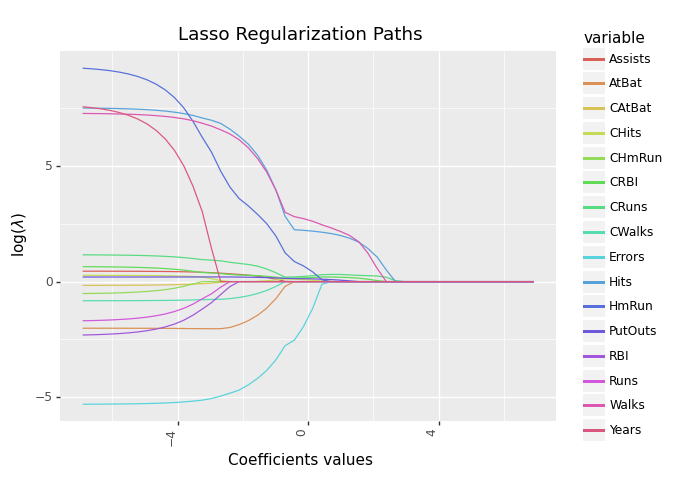

<ggplot: (8771635840078)>

In [0]:
p = plot_regularization_path(trainX, trainY, lambdas, fit_lasso_regression, "Lasso")
ggsave(p, "lasso.regularization.path.png", verbose=False)
p

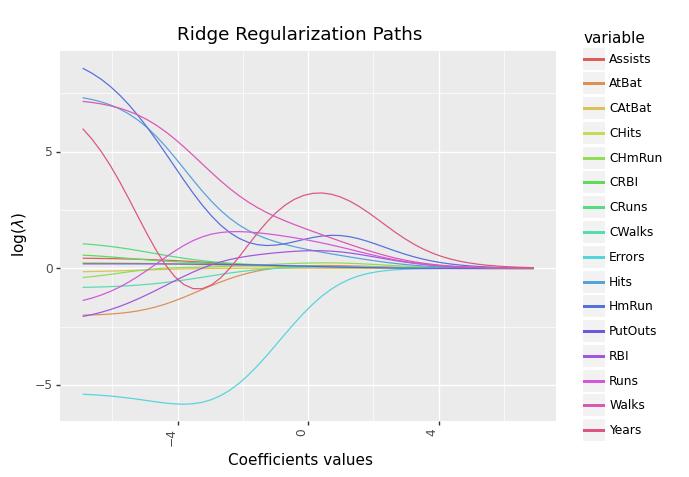

<ggplot: (-9223363265232560987)>

In [0]:
p = plot_regularization_path(trainX, trainY, lambdas, fit_ridge_regression, "Ridge")
ggsave(p, "ridge.regularization.path.png", verbose=False)
p


# How To Deal With Categorical Features 
So far we have fitted a regularization model over data consisting of neumeric features only. In the case of categorical
features, where we decide to represent them using `dummy variables` we move from one feature with $n$ values to $n-1$ features.
What will happen when we fit a regularization model over this kind of setup?

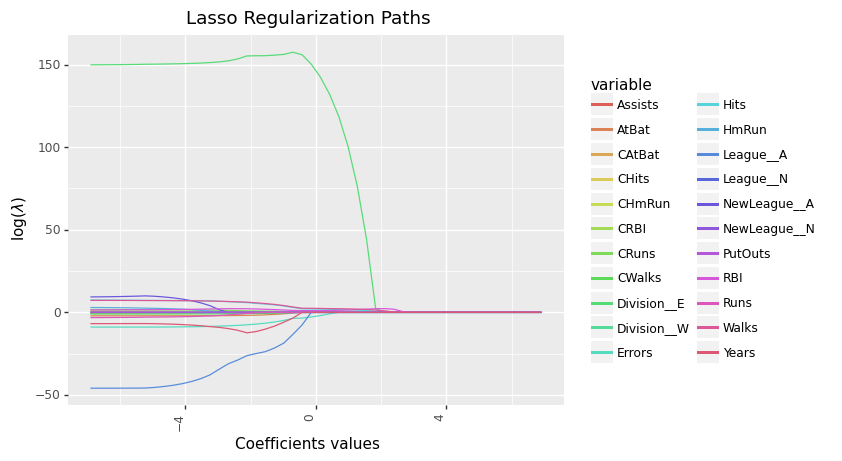

<ggplot: (-9223363265234281598)>

In [0]:
df = pd.read_csv("Hitters.csv").drop("Player", 1).dropna()
df = pd.get_dummies(df, prefix='League_', columns=['League'])
df = pd.get_dummies(df, prefix='Division_', columns=['Division'])
df = pd.get_dummies(df, prefix='NewLeague_', columns=['NewLeague'])

train, test = train_test_split(df, test_size=0.2)
trainX, trainY, testX, testY = train.loc[:, train.columns != 'Salary'], train["Salary"], test.loc[:, test.columns != 'Salary'], test["Salary"]

plot_regularization_path(trainX, trainY, lambdas, fit_lasso_regression, "Lasso")

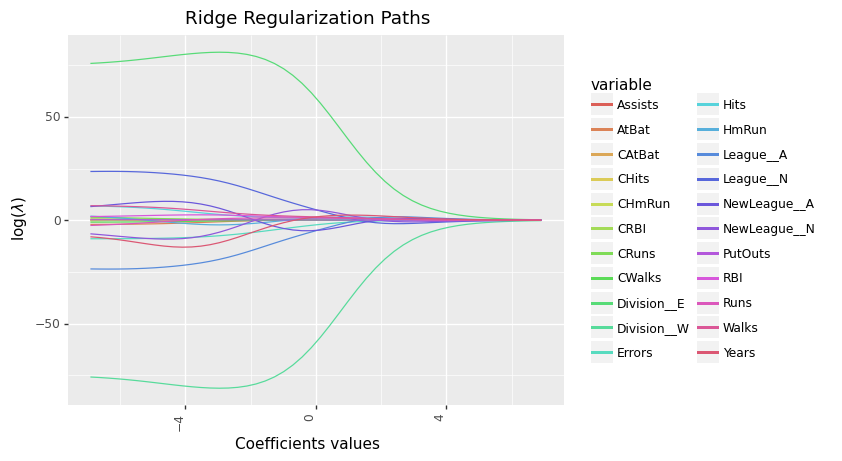

<ggplot: (8771620488417)>

In [0]:
plot_regularization_path(trainX, trainY, lambdas, fit_ridge_regression, "Ridge")


# But How To Choose $\lambda$?!
Now that we better understand how lasso- and ridge regressions work, we face a new problem. We have one new 
parameter (hyper-parameter) to assign a value to. That parameter is $\lambda$. 

The discussion on setting $\lambda$ is part of the next lecture :)